### Coding and Financial Analysis

## Setup

In [1]:
llm_config = {"model": "gpt-4-turbo"}

## Define a code executor

In [2]:
from autogen.coding import LocalCommandLineCodeExecutor

In [3]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
)

## Create agents 

In [4]:
from autogen import ConversableAgent, AssistantAgent

### 1. Agent with code executor configuration

In [5]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

### 2. Agent with code writing capability

In [6]:
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

In [7]:
code_writer_agent_system_message = code_writer_agent.system_message

In [8]:
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

## The task!

Ask the two agents to collaborate on a stock analysis task.

In [9]:
import datetime

today = datetime.datetime.now().date()
message = f"Today is {today}. "\
"Create a plot showing stock gain YTD for NVDA and TLSA. "\
"Make sure the code is in markdown code block and save the figure"\
" to a file ytd_stock_gains.png."""

In [10]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
)

code_executor_agent (to code_writer_agent):

Today is 2025-01-13. Create a plot showing stock gain YTD for NVDA and TLSA. Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To accomplish the task of plotting Year-To-Date (YTD) stock gains for Nvidia (NVDA) and Tesla (TSLA) up to today's date (2025-01-13), we will follow this plan:

1. Fetch historical stock price data for NVDA and TSLA from the beginning of the year 2025 up to today's date.
2. Compute the percentage gain from the first trading day of the year to the specified date.
3. Plot these gains using a graph.
4. Save the graph to a file called `ytd_stock_gains.png`.

To fetch historical stock data, calculate the gains, and plot the results, we will use Python with libraries such as `pandas`, `pandas_datareader`, and `matplotlib`. Ensure these are installed, or

Provide feedback to code_writer_agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: exit


In [22]:
# ploting the plot

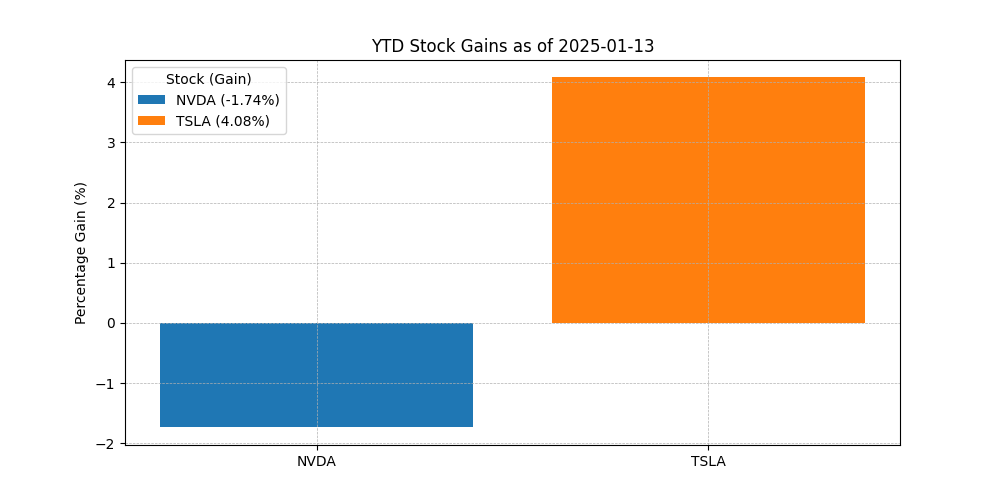

In [11]:
import os
from IPython.display import Image

Image(os.path.join("coding", "ytd_stock_gains.png"))

## User-Defined Functions

Instead of asking LLM to generate the code for downloading stock data 
and plotting charts each time, you can define functions for these two tasks and have LLM call these functions in the code.

In [12]:
def get_stock_prices(stock_symbols, start_date, end_date):
    """Get the stock prices for the given stock symbols between
    the start and end dates.

    Args:
        stock_symbols (str or list): The stock symbols to get the
        prices for.
        start_date (str): The start date in the format 
        'YYYY-MM-DD'.
        end_date (str): The end date in the format 'YYYY-MM-DD'.
    
    Returns:
        pandas.DataFrame: The stock prices for the given stock
        symbols indexed by date, with one column per stock 
        symbol.
    """
    import yfinance

    stock_data = yfinance.download(
        stock_symbols, start=start_date, end=end_date
    )
    return stock_data.get("Close")

In [13]:
def plot_stock_prices(stock_prices, filename):
    """Plot the stock prices for the given stock symbols.

    Args:
        stock_prices (pandas.DataFrame): The stock prices for the 
        given stock symbols.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(
            stock_prices.index, stock_prices[column], label=column
                )
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)

### Create a new executor with the user-defined functions

In [14]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
    functions=[get_stock_prices, plot_stock_prices],
)

In [15]:
code_writer_agent_system_message += executor.format_functions_for_prompt()
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

### Let's update the agents with the new system message

In [16]:
code_writer_agent = ConversableAgent(
    name="code_writer_agent",
    system_message=code_writer_agent_system_message,
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

In [17]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

### Start the same task again!

In [20]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}."
    "Download the stock prices YTD for NVDA and TSLA and create"
    "a plot. Make sure the code is in markdown code block and "
    "save the figure to a file stock_prices_YTD_plot.png.",
)

code_executor_agent (to code_writer_agent):

Today is 2025-01-13.Download the stock prices YTD for NVDA and TSLA and createa plot. Make sure the code is in markdown code block and save the figure to a file stock_prices_YTD_plot.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

Let's start by fetching the YTD (Year-To-Date) stock prices for the companies "NVDA" (NVIDIA Corporation) and "TSLA" (Tesla Inc). Since today's date is 2025-01-13, the start date for YTD would be 2025-01-01. 

I will write a Python script that you will run to perform the following steps:
1. Import necessary functions and libraries.
2. Define the stock symbols and date range.
3. Fetch the stock prices using the `get_stock_prices` function.
4. Generate a plot of these stock prices.
5. Save the plot to a file named 'stock_prices_YTD_plot.png'.

Here's the complete code to perform this task:

```python
# filename: fetch_and_plot_stocks.

### Plot the results

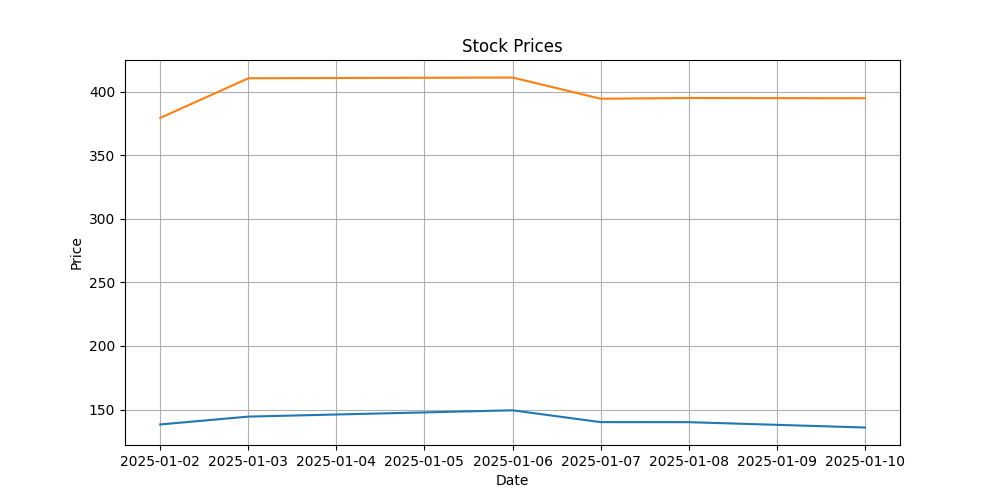

In [21]:
Image(os.path.join("coding", "stock_prices_YTD_plot.png"))